In [1]:
import os

# Go up one level from notebooks/ to project root
os.chdir("..")
print("Current working dir:", os.getcwd())

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'



Current working dir: /Users/ipeaz/Documents/GitHub/HackathonEBM


This notebook is made for sanity checks of our EBM implementation. It should work both on minimal 2D data examples, as well as in higher dimensions, such as MNIST or CIFAR.

# Train an EBM on a 2D MoG dataset
This part is just for validating that our EBM implementation works in a simple toy example. We will train a minimal energy network $E(\boldsymbol{x}), \, \boldsymbol{x} \in \mathbb{R}^2$ to learn the density of a 2-dimensional Mixture of Gaussians. 

There is a config prepared, let's load it and check the model part:

In [2]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="../configs/"):
    config = compose(config_name="mog_ebm") 
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

print(OmegaConf.to_yaml(config.model))

_target_: src.models.EBM
_recursive_: false
buffer_size: 128
wgan_gp_lambda: 0.0
l2_energy_lambda: 0.01
l2_params_lambda: 0.0
energy_net:
  _target_: src.layers.MLP
  input_dim: 2
  hidden_dims:
  - 32
  - 32
  - 32
  output_dim: 1
  activation: swish
sampler:
  _target_: src.samplers.SGLD
  input_dim: ${data.dim}
  input_shape: ${data.shape}
  sample_size: ${train.batch_size}
  steps: 30
  step_size: 0.01
  noise_std: 1.0



/var/folders/p5/xh_l00hj0xs35gf0ndj424wm0000gq/T/ipykernel_65382/2293751337.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mog_ebm': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


As you can see, the energy network is quite small, and we are not even adding any type of regularization here. The `step_size` is also quite small, since gradient norm is quite decent here, unlike for MNIST, as we will see.

Let's check how the MoG is called:

In [3]:
print(OmegaConf.to_yaml(config.data))

shape:
- 1
- 1
dim: 2
root: mog/
dataset:
  _target_: src.data.MoGDataset
  root: ${data.root}
  weights:
  - 0.3
  - 0.4
  - 0.3
train_dataset:
  n_samples: 1000
dataloader:
  _target_: torch.utils.data.DataLoader
  batch_size: ${train.batch_size}
  num_workers: 0
  pin_memory: false



The class `src.data.MoGDataset` generates the samples from a pre-defined MoG, where we can change its parameters. For example, here we are defining our new weights $\pi_1=0.3, \pi_2=0.4, \pi_3=0.3$.

In [4]:
from hydra.utils import instantiate
from pytorch_lightning import Trainer
from src.data.utils import get_data_loaders
from src.utils import get_wandb_logger

# Logger
wandb_logger, _ = get_wandb_logger(config, "mog_ebm")

# Loader for biased dataset
loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]

# Initialize model
ebm = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    default_root_dir=None,       # ensures no `lightning_logs/` folder is created
    logger=wandb_logger,
)

/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

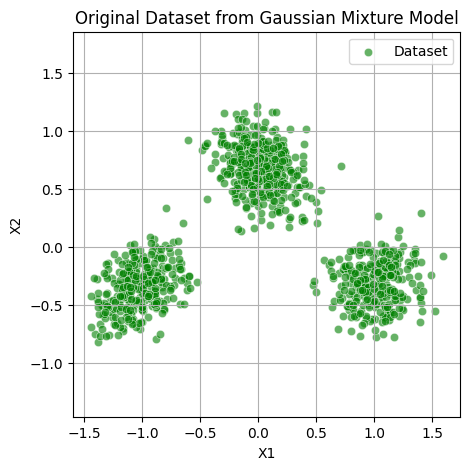

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

data = loaders[0].dataset.data.squeeze()  # Remove extra dimensions

# Plot the two datasets
plt.figure(figsize=(5,5))
sns.scatterplot(x=data[:, 0], y=data[:, 1], color='green', alpha=0.6)

plt.title('Original Dataset from Gaussian Mixture Model')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid()

plt.legend(['Dataset'])
plt.show()

In [6]:
trainer.fit(ebm, loaders[0])

/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
wandb: Currently logged in as: ipeis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name       | Type | Params | Mode 
--------------------------------------------
0 | energy_net | MLP  | 2.2 K  | train
1 | sampler    | SGLD | 0      | train
--------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for t

Epoch 1999: 100%|██████████| 8/8 [00:00<00:00, 40.88it/s, v_num=vzyv, train/loss=0.0101]   

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 8/8 [00:00<00:00, 39.09it/s, v_num=vzyv, train/loss=0.0101]


Let's get some samples. Here, we increase the number of Langevin steps to 100, to ensure the chains reach a proper state.

In [7]:
samples = ebm.sample(1000, steps=100).detach().squeeze().cpu().numpy() # (1000, num_steps, 2)

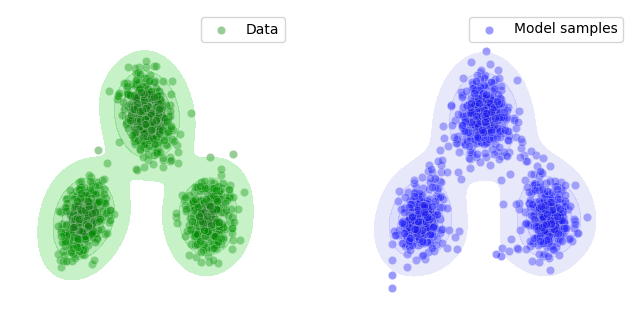

In [8]:
def plot_kde_contours(data, samples):
    # Plot subplots with kde contours of the training data and VAE samples
    f, ax = plt.subplots(1,2, figsize=(8,4))

    sns.scatterplot(x=data[:, 0], y=data[:, 1], label='Data', color='green', alpha=0.4, ax=ax[0])
    sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=5, color='green', label='True density', fill=True, alpha=0.3, ax=ax[0])

    # Get axis limits
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()

    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], label='Model samples', color='blue', alpha=0.4, ax=ax[1])
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], levels=5, color='blue', label='Model density', fill=True, alpha=0.3, ax=ax[1])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)

    # Legend
    ax[0].axis('off'); ax[1].axis('off');

plot_kde_contours(data, samples)

# Train an EBM on MNIST

Now, we move to a much higher dimensional data and challenging data (compared to the previous) to be captured by our EBM. Let's check the config for MNIST:

In [9]:
with initialize(config_path="../configs/"):
    config = compose(config_name="mnist_ebm") 
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

print(OmegaConf.to_yaml(config.model))

_target_: src.models.EBM
_recursive_: false
buffer_size: 8192
init_dist: uniform
wgan_gp_lambda: 0.0
l2_energy_lambda: 0.01
l2_params_lambda: 0.001
energy_net:
  _target_: src.layers.ConvEncoder
  input_channels: ${data.dim}
  input_shape: ${data.shape}
  latent_dim: 1
  hidden_channels:
  - 32
  - 64
  - 128
  - 128
  kernel_sizes:
  - 5
  - 3
  - 3
  - 3
  strides:
  - 2
  - 2
  - 2
  - 2
  paddings:
  - 4
  - 1
  - 1
  - 1
  batch_norm: false
  activation: swish
  probabilistic: false
sampler:
  _target_: src.samplers.SGLD
  input_dim: ${data.dim}
  input_shape: ${data.shape}
  sample_size: ${train.batch_size}
  steps: 60
  step_size: 4
  noise_std: 0.005
  clip_grads: true
  clamp: true



/var/folders/p5/xh_l00hj0xs35gf0ndj424wm0000gq/T/ipykernel_65382/2635502396.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/Users/ipeaz/miniconda3/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mnist_ebm': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


You could train the model yourself, but let's save time and load one that it's already trained.

In [10]:
from src.utils import load_model

# Put here the path to your checkpoint
ckpt_path = os.path.join(log_dir, 'logs', 'EBM_Hackathon', 'mnist_ebm-2025-11-13T12-55-54', 'checkpoints', 'last.ckpt')
# Load model from checkpoint
model, config = load_model(ckpt_path=ckpt_path)

Restored from ./logs/EBM_Hackathon/mnist_ebm-2025-11-13T12-55-54/checkpoints/last.ckpt


Let's get some samples:

In [11]:
samples = model.sample(64, steps=100)

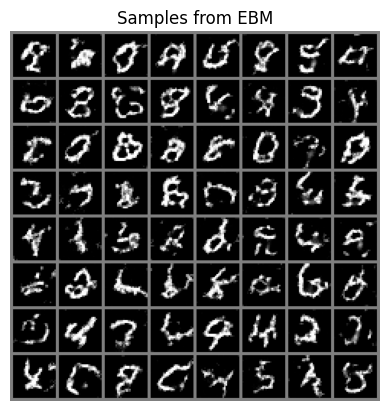

In [12]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 

samples = make_grid(samples, nrow=8)

# Move to [0,1]
samples = (samples + 1) / 2

# Plot samples side by side
fig, ax = plt.subplots()
ax.imshow(samples.permute(1, 2, 0).cpu().numpy(), cmap='gray')
ax.set_title('Samples from EBM')
ax.axis('off')
plt.show()